## Построение GNN для классификации узлов с использованием PyG

### Пример 1. Классификация узлов датасета Cora

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        # edge_index - это тензор [2, num_edges]
        # отличие от DGL - модули PyG принимают
        # на вход эти тензоры, а не объект графа 
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [11]:
from torch_geometric.datasets import Planetoid
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Planetoid(root='./tmp', name='Cora')
G = dataset[0].to(device)
model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(G)
    loss = F.nll_loss(out[G.train_mask], G.y[G.train_mask])
    loss.backward()
    optimizer.step()

In [12]:
model.eval()
pred = model(G).argmax(dim=1)
correct = (pred[G.test_mask] == G.y[G.test_mask]).sum()
acc = int(correct) / int(G.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8120


### Пример 2. Классификация узлов датасета KarateClub

In [5]:
# несколько удобных функций для описания датасетов
def describe_dataset(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

def describe_graph(g):
    print(g)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {g.num_nodes}')
    print(f'Number of edges: {g.num_edges}')
    print(f'Average node degree: {g.num_edges / g.num_nodes:.2f}')
    print(f'Number of training nodes: {g.train_mask.sum()}')
    print(f'Training node label rate: {int(g.train_mask.sum()) / g.num_nodes:.2f}')
    print(f'Has isolated nodes: {g.has_isolated_nodes()}')
    print(f'Has self-loops: {g.has_self_loops()}')
    print(f'Is undirected: {g.is_undirected()}')

In [29]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
g = dataset[0]
describe_dataset(dataset)
describe_graph(g)

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as gnn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(
        self, 
        n_input: int, 
        n_hidden_layers: int, 
        n_hidden: int, 
        n_out: int,
        n_classes: int,
        dropout_p: float = 0.2,
        activation: callable = F.relu
    ) -> None:
        super().__init__()
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        if n_hidden_layers > 1:
            self.layers.append(gnn.GCNConv(n_input, n_hidden))
            for _ in range(1, n_hidden_layers-1):
                self.layers.append(gnn.GCNConv(n_hidden, n_hidden))
            self.layers.append(gnn.GCNConv(n_hidden, n_out))
        else:
            self.layers.append(gnn.GCNConv(n_input, n_out))
        self.classifier = nn.Linear(n_out, n_classes)
        self.activation = activation

    def forward(self, x, edge_index):
        h = x
        for layer in self.layers:
            h = layer(h, edge_index)
            h = self.activation(h)
            h = F.dropout(h, p=self.dropout_p, training=self.training)
        logits = self.classifier(h)
        return logits, h

E:\anaconda3\envs\gcn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
model = GCN(
    n_input=dataset.num_features, 
    n_hidden_layers=3, 
    n_hidden=4,
    n_out=2, 
    n_classes=dataset.num_classes, 
    activation=torch.tanh,
    dropout_p=0
)
print(model)

GCN(
  (layers): ModuleList(
    (0): GCNConv(34, 4)
    (1): GCNConv(4, 4)
    (2): GCNConv(4, 2)
  )
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embedding(h, color, epoch=None, loss=None, figsize=(7, 7)):
    # отобразить двумерные векторы на плоскости
    # если векторы имеют большую размерность, получаем двумерное представление
    # при помощи t-SNE
    fig, ax = plt.subplots(figsize=figsize)
    if epoch is not None and loss is not None:
        ax.set_xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    if h.shape[-1] == 2:
        emb_2d = h.detach().cpu().numpy()
    else:
        emb_2d = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], s=140, c=color, cmap="Set2")

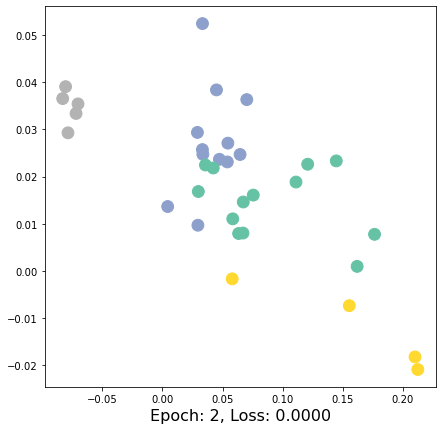

In [20]:
_, embeddings = model(g.x, g.edge_index)
visualize_embedding(embeddings, color=g.y, loss=torch.tensor([0]), epoch=2)

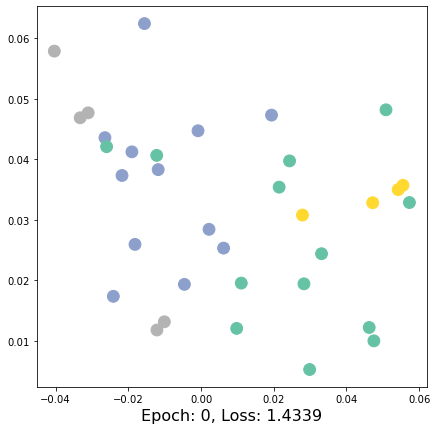

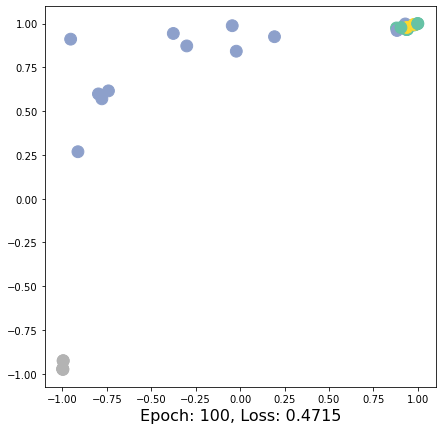

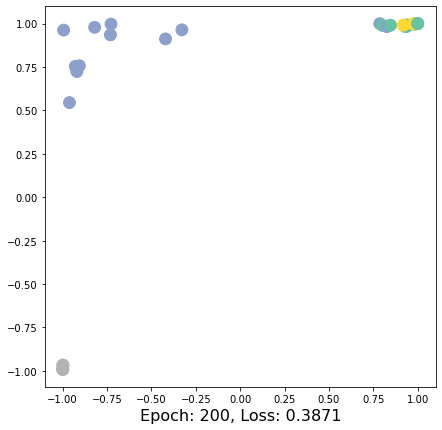

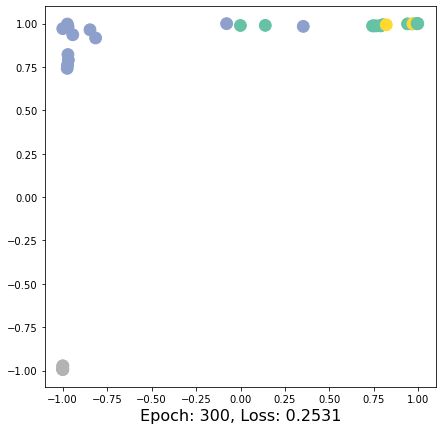

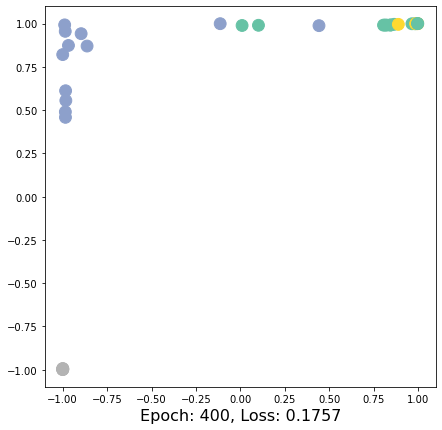

In [24]:
model = GCN(
    n_input=dataset.num_features, 
    n_hidden_layers=3, 
    n_hidden=4,
    n_out=2, 
    n_classes=dataset.num_classes, 
    activation=torch.tanh,
    dropout_p=0
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)

for epoch in range(401):
    logits, embeddings = model(g.x, g.edge_index)
    loss = criterion(logits[g.train_mask], g.y[g.train_mask])
    loss.backward()  
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        visualize_embedding(embeddings, color=g.y, epoch=epoch, loss=loss)

### Пример 3. Классификация узлов датасета Cora

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='./tmp/Planetoid', name='Cora', transform=NormalizeFeatures())

E:\anaconda3\envs\gcn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
describe_dataset(dataset)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [7]:
g = dataset[0]
describe_graph(g)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.nn as gnn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(
        self, 
        n_input: int, 
        n_hidden_layers: int, 
        n_hidden: int, 
        n_out: int,
        n_classes: int,
        dropout_p: float = 0.2,
        activation: callable = F.relu,
        add_fc: bool = True
    ) -> None:
        super().__init__()
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        # возможность добавить полносвязный слой после сверточных
        self.add_fc = add_fc
        n_out = n_out if add_fc else n_classes
        if n_hidden_layers > 1:
            self.layers.append(gnn.GCNConv(n_input, n_hidden))
            for _ in range(1, n_hidden_layers-1):
                self.layers.append(gnn.GCNConv(n_hidden, n_hidden))
            self.layers.append(gnn.GCNConv(n_hidden, n_out))
        else:
            self.layers.append(gnn.GCNConv(n_input, n_out))
        if add_fc:
            self.fc = nn.Linear(n_out, n_classes)
        self.activation = activation

    def forward(self, x, edge_index):
        h = x
        for idx, layer in enumerate(self.layers):
            h = layer(h, edge_index)
            if idx != len(self.layers) - 1 or self.add_fc:
                h = self.activation(h)
                h = F.dropout(h, p=self.dropout_p, training=self.training)
        if self.add_fc:
            h = self.fc(h)
        return h

GCN(
  (layers): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 7)
  )
)
Epoch: 000, Loss: 1.9458
Epoch: 010, Loss: 1.8493
Epoch: 020, Loss: 1.6992
Epoch: 030, Loss: 1.5073
Epoch: 040, Loss: 1.2731
Epoch: 050, Loss: 1.0859
Epoch: 060, Loss: 0.8739
Epoch: 070, Loss: 0.7294
Epoch: 080, Loss: 0.6378
Epoch: 090, Loss: 0.5463
Epoch: 100, Loss: 0.5303


E:\anaconda3\envs\gcn\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\anaconda3\envs\gcn\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


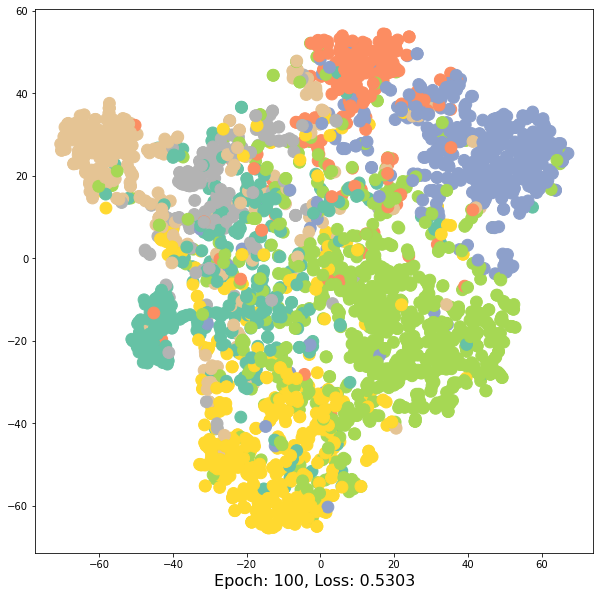

In [26]:
model = GCN(
    n_input=dataset.num_features, 
    n_hidden_layers=2, 
    n_hidden=16,
    n_out=16, 
    n_classes=dataset.num_classes,
    activation=torch.relu,
    dropout_p=0.5,
    add_fc=False
)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01, weight_decay=5e-4)

for epoch in range(101):
    logits = model(g.x, g.edge_index)
    loss = criterion(logits[g.train_mask], g.y[g.train_mask])
    loss.backward()  
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')
visualize_embedding(logits, color=g.y, epoch=epoch, loss=loss, figsize=(10,10))
# результаты показывают, что полносвязный слой в конец лучше не добавлять

In [28]:
model.eval()
logits = model(g.x, g.edge_index)
preds = logits.argmax(dim=1)
test_correct = preds[g.test_mask] == g.y[g.test_mask]
test_acc = test_correct.sum() / g.test_mask.sum()
test_acc

tensor(0.8220)

### 4. Использование GATConv

In [31]:
describe_graph(g)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [38]:
conv = gnn.GATConv(in_channels=g.x.shape[-1], out_channels=16, heads=2, concat=True)
h = conv(g.x, g.edge_index)
# размерность выхода: out_channels * heads (если concat=True)
h.shape

torch.Size([2708, 32])

In [58]:
class GAT(nn.Module):
    def __init__(
        self, 
        n_input:int, 
        n_hidden: int = 8, 
        n_out: int = 2, 
        n_heads: tuple = (8, 1),
        dropout_p: float = .6,
        activation: callable = torch.relu
    ):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        self.activation = activation
        if len(n_heads) > 1:
            self.layers.append(gnn.GATConv(n_input, n_hidden, heads=n_heads[0], dropout=dropout_p))
            for i in range(1, len(n_heads)-1):
                self.layers.append(gnn.GATConv(n_hidden * n_heads[i-1], n_hidden, heads=n_heads[i], dropout=dropout_p))
            self.layers.append(gnn.GATConv(n_hidden * n_heads[-2], n_out, heads=n_heads[-1], dropout=dropout_p))
        else:
            self.layers.append(gnn.GATConv(n_input, n_out, heads=n_heads[0], dropout=dropout_p, concat=False))
        
    def forward(self, x, edge_index):
        h = x
        for idx, layer in enumerate(self.layers):
            h = layer(h, edge_index)
            if idx != len(self.layers) - 1:
                h = self.activation(h)
                h = F.dropout(h, p=self.dropout_p, training=self.training)
        return h

GAT(
  (layers): ModuleList(
    (0): GATConv(1433, 8, heads=8)
    (1): GATConv(64, 7, heads=1)
  )
)
Epoch: 000, Loss: 1.9467
Epoch: 010, Loss: 1.7837
Epoch: 020, Loss: 1.5343
Epoch: 030, Loss: 1.1831
Epoch: 040, Loss: 1.0295
Epoch: 050, Loss: 0.8248
Epoch: 060, Loss: 0.7898
Epoch: 070, Loss: 0.5822
Epoch: 080, Loss: 0.6555
Epoch: 090, Loss: 0.5997
Epoch: 100, Loss: 0.5573
Test acc= 0.8050000071525574


E:\anaconda3\envs\gcn\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\anaconda3\envs\gcn\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


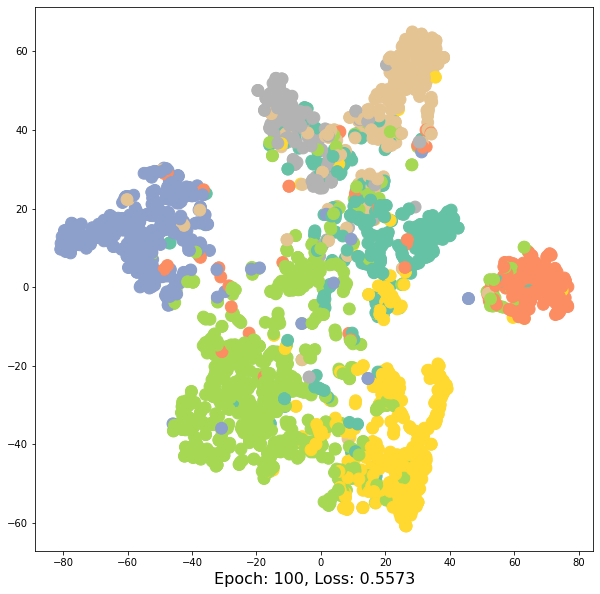

In [62]:
model = GAT(
    n_input=dataset.num_features, 
    n_hidden=8,
    n_out=dataset.num_classes, 
    n_heads=(8, 1),
    activation=torch.relu,
    dropout_p=0.5,
)
print(model)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01, weight_decay=5e-4)

for epoch in range(101):
    logits = model(g.x, g.edge_index)
    loss = criterion(logits[g.train_mask], g.y[g.train_mask])
    loss.backward()  
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')

model.eval()
logits = model(g.x, g.edge_index)
preds = logits.argmax(dim=1)
test_correct = preds[g.test_mask] == g.y[g.test_mask]
test_acc = test_correct.sum() / g.test_mask.sum()
print('Test acc=', test_acc.item())

visualize_embedding(logits, color=g.y, epoch=epoch, loss=loss, figsize=(10,10))
